Цель проекта:

Проанализируйте данные.
Проведите корреляционный анализ.
Обучите следующие модели и сравните результаты:
Logistic Regression;
Randomforest;
Neural Network.

* Age (возраст);
* Sex (пол);
* Resting_blood_pressure (артериальное давление в состоянии покоя);
* Serum_cholestoral (уровень холестерина в крови mg/dl);
* Fasting_blood_sugar (анализ глюкозы в крови натощак (> 120 mg/dl));
* Maximum_heart_rate_achieved (максимальная частота сердечных сокращений);
* Exercise_induced_angina (стенокардия при нагрузке),
* Oldpeak (депрессия ST-сегмента);
* Slope (наклон пикового сегмента ST при физической нагрузке);
* Number_of_major_vessels (количество крупных сосудов (0-3), окрашенных с помощью флюороскопии);
* Resting_electrocardiographic_results (результаты электрокардиографических исследований в покое 0, 1, 2);
* Thal (3 = норма; 6 = фиксированный дефект; 7 = обратимый дефект);
* Chest_bin (боль в груди от 1 до 4).

основные этапы:
* обработка выбросов
* проверка на дубликаты
* нормализация и стандартизация
* балансировка классов
* матрица корреляции
* удаление неинформативных признаков
* построение моделей: логистическая регрессия, рандомный лес, нейронные сети
 

Импорт библиотек и загрузка данных

In [382]:
import pandas as pd
import numpy as np
import seaborn as sns                # Импорт библиотеки seaborn для создания красивых и информативных визуализаций данных
import seaborn as snsfrom 
from matplotlib import pyplot as plt # Импорт функции pyplot из библиотеки matplotlib для создания графиков и визуализаций
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
)

from sklearn.model_selection import (
    StratifiedKFold,
    cross_validate,
    cross_val_score,
    KFold
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    multilabel_confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve,
    average_precision_score,
    precision_recall_curve
)
from sklearn.metrics import classification_report


from sklearn.tree import plot_tree  # Функция для визуализации структуры дерева решений

from scipy.stats import (           # Модули для работы с распределениями, позволяющие генерировать
    uniform,                        # выборки из равномерного
    randint                         # и дискретного равномерного распределений
)

# Функция для оценки важности признаков, основанная на изменении точности модели при перестановке значений признаков
from sklearn.inspection import permutation_importance
cardio_train = pd.read_csv('data/heart_pred/train.csv', sep=',')

## 1. Предобработка данных

In [383]:
cardio_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 15 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ID                                    600000 non-null  int64  
 1   age                                   600000 non-null  float64
 2   sex                                   600000 non-null  int64  
 3   chest                                 600000 non-null  float64
 4   resting_blood_pressure                600000 non-null  float64
 5   serum_cholestoral                     600000 non-null  float64
 6   fasting_blood_sugar                   600000 non-null  int64  
 7   resting_electrocardiographic_results  600000 non-null  int64  
 8   maximum_heart_rate_achieved           600000 non-null  float64
 9   exercise_induced_angina               600000 non-null  int64  
 10  oldpeak                               600000 non-null  float64
 11  

In [384]:
cardio_test = pd.read_csv('data/heart_pred/test.csv', sep=',')

In [385]:
cardio_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 14 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ID                                    400000 non-null  int64  
 1   age                                   400000 non-null  float64
 2   sex                                   400000 non-null  int64  
 3   chest                                 400000 non-null  float64
 4   resting_blood_pressure                400000 non-null  float64
 5   serum_cholestoral                     400000 non-null  float64
 6   fasting_blood_sugar                   400000 non-null  int64  
 7   resting_electrocardiographic_results  400000 non-null  int64  
 8   maximum_heart_rate_achieved           400000 non-null  float64
 9   exercise_induced_angina               400000 non-null  int64  
 10  oldpeak                               400000 non-null  float64
 11  

In [386]:
cardio_train.describe(include='all').round(2).T

,count,mean,std,min,25%,50%,75%,max
ID,600000.0,299999.50,173205.23,0.00,149999.75,299999.50,449999.25,599999.00
age,600000.0,54.43,9.09,26.06,48.08,55.13,60.66,79.59
sex,600000.0,0.68,0.47,0.00,0.00,1.00,1.00,1.00
chest,600000.0,3.17,0.95,-0.54,3.00,3.00,4.00,4.00
resting_blood_pressure,600000.0,131.34,17.84,82.92,119.92,129.73,139.92,209.67
serum_cholestoral,600000.0,249.59,51.70,98.33,216.48,244.23,274.35,527.76
fasting_blood_sugar,600000.0,0.15,0.36,0.00,0.00,0.00,0.00,1.00
resting_electrocardiographic_results,600000.0,1.02,0.99,0.00,0.00,2.00,2.00,2.00
maximum_heart_rate_achieved,600000.0,149.59,23.07,61.84,135.70,153.22,165.17,208.74
exercise_induced_angina,600000.0,0.33,0.47,0.00,0.00,0.00,1.00,1.00


In [387]:
cardio_test.describe(include='all').round(2).T

,count,mean,std,min,25%,50%,75%,max
ID,400000.0,799999.50,115470.20,600000.00,699999.75,799999.50,899999.25,999999.00
age,400000.0,54.41,9.10,27.50,48.02,55.13,60.67,80.75
sex,400000.0,0.68,0.47,0.00,0.00,1.00,1.00,1.00
chest,400000.0,3.17,0.95,-0.34,3.00,3.00,4.00,4.00
resting_blood_pressure,400000.0,131.37,17.86,85.83,119.94,129.74,139.94,212.30
serum_cholestoral,400000.0,249.59,51.72,94.96,216.46,244.27,274.36,527.71
fasting_blood_sugar,400000.0,0.15,0.36,0.00,0.00,0.00,0.00,1.00
resting_electrocardiographic_results,400000.0,1.03,0.99,0.00,0.00,2.00,2.00,2.00
maximum_heart_rate_achieved,400000.0,149.66,23.07,58.96,135.82,153.34,165.22,207.41
exercise_induced_angina,400000.0,0.33,0.47,0.00,0.00,0.00,1.00,1.00


**Общая информация о данных**:
   - Обучающий набор (`cardio_train`) содержит 600,000 записей с 15 столбцами (включая целевой `class`).
   - Тестовый набор (`cardio_test`) содержит 400,000 записей с 14 столбцами (без целевого `class`).


   **Описательная статистика**:
   - Средний возраст пациентов: ~54 года.
   - Среднее артериальное давление: ~131 мм рт.ст.
   - Средний уровень холестерина: ~249 мг/дл.
   - Распределение целевой переменной (`class`): 44% пациентов имеют заболевание сердца (класс 1), 56% — нет (класс 0).

Проверка на дубликаты

In [388]:
duplicates = cardio_train[cardio_train.duplicated(keep=False)]  # keep=False помечает все дубли
print(f"Количество полных дубликатов: {len(duplicates)}")

if len(duplicates) > 0:
    print("\nПример дублированных строк:")
    display(duplicates.head())

Количество полных дубликатов: 0


In [389]:
duplicates = cardio_test[cardio_test.duplicated(keep=False)]  # keep=False помечает все дубли
print(f"Количество полных дубликатов: {len(duplicates)}")

if len(duplicates) > 0:
    print("\nПример дублированных строк:")
    display(duplicates.head())

Количество полных дубликатов: 0


In [390]:
df=cardio_train.drop(['ID'], axis=1)
df.head()

,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal,class
0,49.207124,0,4.000000,162.996167,181.108682,0,0,148.227858,1,0.944547,2,0,3,1
1,53.628425,1,1.741596,130.233730,276.474630,0,2,152.917139,0,0.119070,2,0,3,0
2,49.591426,1,4.000000,146.999012,223.300517,1,2,102.352090,1,1.616747,2,2,7,1
3,58.991445,1,4.000000,112.369143,187.245501,0,0,158.164750,1,0.000000,1,1,7,1
4,51.053602,1,1.954609,138.032047,238.482868,0,0,172.540828,0,1.150464,1,1,3,0


In [391]:
duplicates = df[df.duplicated(keep=False)]  # keep=False помечает все дубли
print(f"Количество полных дубликатов: {len(duplicates)}")

if len(duplicates) > 0:
    print("\nПример дублированных строк:")
    display(duplicates.head())

Количество полных дубликатов: 0


In [392]:
df_test=cardio_test.drop(['ID'], axis=1)
df_test.head()

,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal
0,53.963191,1,4.000000,136.940829,236.862814,0,2,143.961525,1,0.711100,1,2,7
1,49.621479,1,4.000000,122.024651,226.593019,0,2,112.220874,1,0.000000,1,1,7
2,36.933893,1,1.300924,127.585643,351.061046,0,0,177.945922,0,0.313078,1,0,7
3,54.884588,1,3.000000,124.876745,250.370530,0,0,153.176526,0,0.308277,1,1,7
4,71.016392,0,1.746972,120.922600,210.979710,0,0,164.573122,0,1.021370,1,1,3


In [393]:
for column in ['age', 'resting_blood_pressure', 'serum_cholestoral', 'maximum_heart_rate_achieved', 'oldpeak']:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    выбросы_iqr = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(выбросы_iqr.index)
    print(f"Количество выбросов в столбце {column} (IQR): {len(выбросы_iqr)}")


Index([  1384,  17757,  46601,  84377, 117167, 118516, 183921, 196892, 203625,
       221841, 225080, 304232, 322309, 347921, 405556, 408520, 422422, 431210,
       435327, 535792, 540160, 550552, 583037],
      dtype='int64')
Количество выбросов в столбце age (IQR): 23
Index([    23,     43,     57,     63,    114,    142,    157,    223,    270,
          294,
       ...
       599823, 599838, 599858, 599873, 599874, 599935, 599955, 599961, 599970,
       599999],
      dtype='int64', length=21129)
Количество выбросов в столбце resting_blood_pressure (IQR): 21129
Index([    32,     68,    102,    110,    134,    168,    204,    237,    286,
          339,
       ...
       599740, 599745, 599796, 599798, 599806, 599812, 599837, 599878, 599907,
       599984],
      dtype='int64', length=24342)
Количество выбросов в столбце serum_cholestoral (IQR): 24342
Index([    98,    264,    600,    996,   1137,   1167,   1168,   1185,   1312,
         1469,
       ...
       599135, 599152, 5993

Примеры выбросов в столбце resting_blood_pressure 

In [394]:
df.iloc[[23,     43,     57,     63,    114,    142,    157,    223,    270, 294]]

,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal,class
23,43.058975,0,1.995429,194.120833,212.535708,0,2,185.872258,0,0.146310,2,0,3,0
43,70.734921,0,4.000000,182.234045,213.774538,1,2,110.613754,1,0.000000,2,2,3,1
57,41.737465,0,1.463197,177.045518,355.143592,0,0,160.535109,0,0.000000,1,0,3,0
63,35.521136,0,3.000000,180.868688,237.309413,0,0,192.922503,0,2.449673,3,0,3,0
114,56.010238,0,4.000000,177.317986,205.156115,0,2,187.930904,0,2.221732,1,0,3,0
142,68.004752,1,4.000000,172.498990,227.542602,0,0,145.990209,0,1.434958,2,1,7,1
157,60.458694,1,4.000000,173.345494,254.888525,0,0,104.240894,1,0.470516,2,0,7,1
223,59.719420,1,1.969717,177.298502,207.409745,0,0,115.381601,1,1.941160,2,2,7,1
270,66.956327,0,3.000000,182.928873,360.065459,0,0,97.912628,1,2.527084,3,1,7,1
294,42.111329,1,4.000000,187.636098,196.419274,0,2,133.122408,1,1.768058,2,1,7,1


Визуализация выбросов

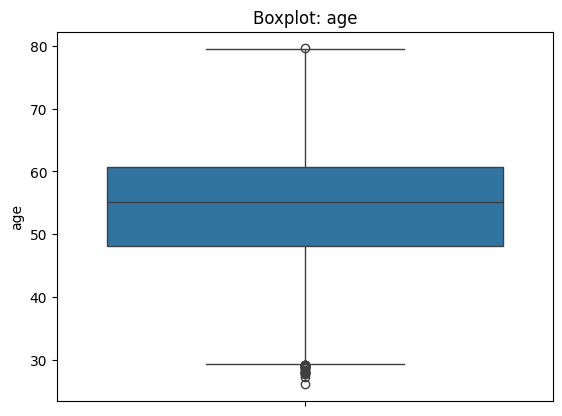

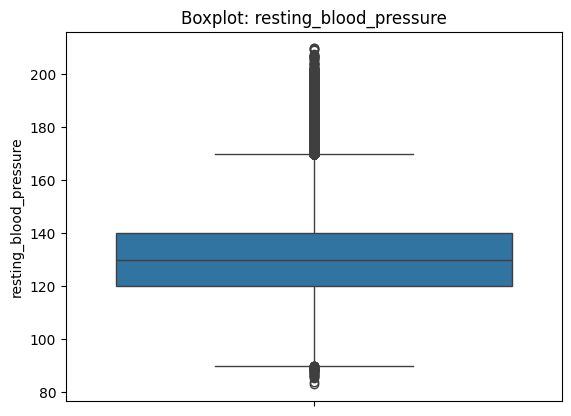

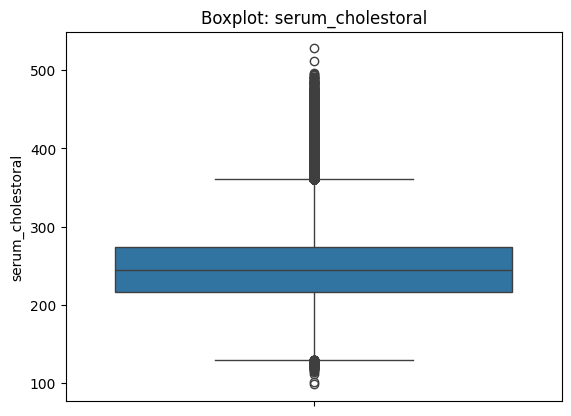

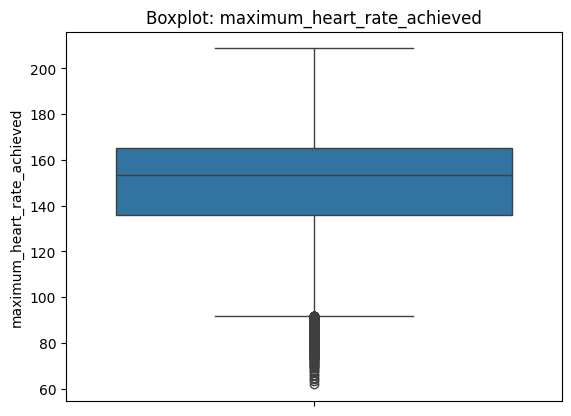

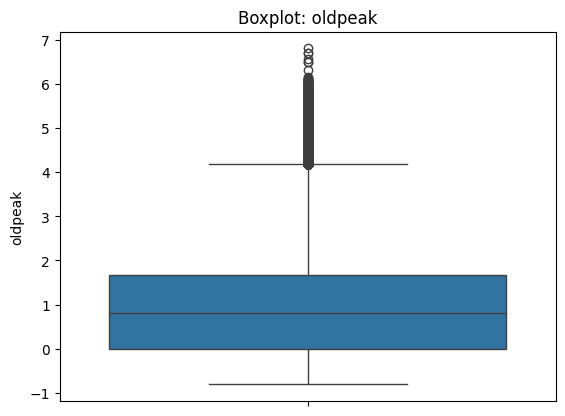

In [395]:
for column in ['age', 'resting_blood_pressure', 'serum_cholestoral', 'maximum_heart_rate_achieved', 'oldpeak']:
    sns.boxplot(df[column])
    plt.title(f"Boxplot: {column}")
    plt.show()

- Гистограммы и boxplot показали распределение и наличие выбросов в числовых признаках.
Обнаружены выбросы в признаках: `age` (23), `resting_blood_pressure` (21,129), `serum_cholesterol` (24,342), `maximum_heart_rate_achieved` (3,316), `oldpeak` (9,533)
- Визуализация выбросов показала, что не требуется активной очистки данных, поскольку:
* выбросы могут отражать реальные патологические состояния пациентов
* требуется сохранение информации (удаление 3-4% данных привело бы к потере клинически важных случаев)

In [396]:
negative_oldpeak=df[df['oldpeak']<0]
print(f"Patients with 'negative oldpeak':{len(negative_oldpeak)}")

Patients with 'negative oldpeak':2365


In [397]:
print(negative_oldpeak["class"].value_counts(normalize=True))

class
0    0.756025
1    0.243975
Name: proportion, dtype: float64


In [398]:
negative_oldpeak=df_test[df_test['oldpeak']<0]
print(f"Patients with 'negative oldpeak':{len(negative_oldpeak)}")

Patients with 'negative oldpeak':1606


In [399]:
mask=(df['oldpeak']<0)&(df['chest']==2)
print(f"пациенты с подъемом ST и болью: {len(df[mask])}")

пациенты с подъемом ST и болью: 0


Обнаружено 2365 пациентов (0.4%) с отрицательным oldpeak, но большая часть здоровы, что говорит об ошибках в данных

заменим отрицательные значения на 0

In [400]:

df.loc[df['oldpeak']<0,'oldpeak']=0
df_test.loc[df_test['oldpeak']<0,'oldpeak']=0

<function matplotlib.pyplot.show(close=None, block=None)>

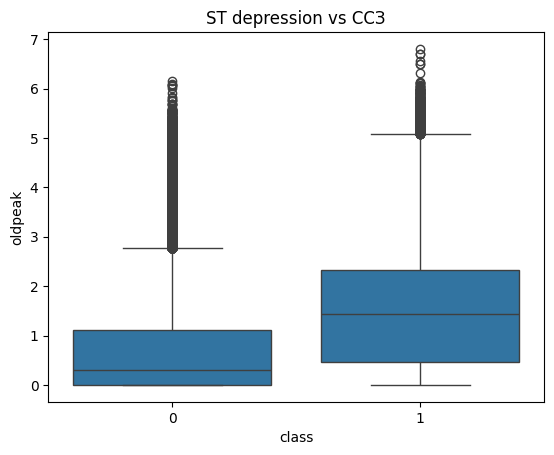

In [401]:
sns.boxplot(x='class', y='oldpeak',data=df)
plt.title("ST depression vs ССЗ")
plt.show


Распределение признака **sex**:
sex
1    0.677447
0    0.322553
Name: proportion, dtype: float64
--------------------------------------------------

Распределение признака **chest**:
chest
4.000000    0.475573
3.000000    0.293622
1.590429    0.000007
1.639221    0.000007
1.782514    0.000007
              ...   
2.158864    0.000002
1.308036    0.000002
1.893928    0.000002
1.180549    0.000002
1.295676    0.000002
Name: proportion, Length: 133009, dtype: float64
--------------------------------------------------

Распределение признака **fasting_blood_sugar**:
fasting_blood_sugar
0    0.849243
1    0.150757
Name: proportion, dtype: float64
--------------------------------------------------

Распределение признака **resting_electrocardiographic_results**:
resting_electrocardiographic_results
2    0.504497
0    0.484348
1    0.011155
Name: proportion, dtype: float64
--------------------------------------------------

Распределение признака **exercise_induced_angina**:
exercise_induced

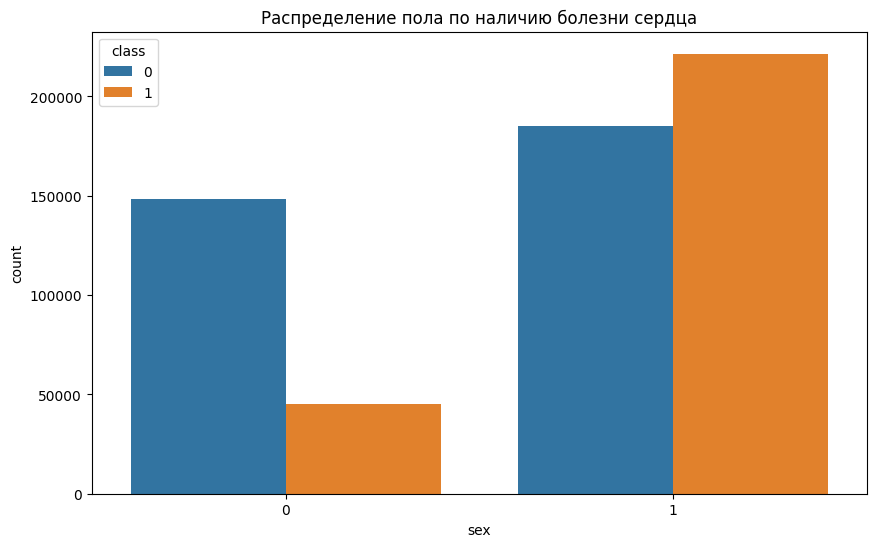

In [402]:
categorical_cols = ['sex', 'chest', 'fasting_blood_sugar', 
                    'resting_electrocardiographic_results', 
                    'exercise_induced_angina', 'slope', 
                    'number_of_major_vessels', 'thal', 'class']

for col in categorical_cols:
    print(f"\nРаспределение признака **{col}**:")
    print(df[col].value_counts(normalize=True))  
    print("-" * 50)

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sex', hue='class')
plt.title("Распределение пола по наличию болезни сердца")
plt.show()

In [403]:
def plot_hist(df, column):
    temp_df = df.copy()
    plt.figure(figsize=(10, 6))

    # Гистограмма
    n, bins, patches = plt.hist(
        temp_df[column], 
        bins=30, 
        color='skyblue', 
        alpha=0.7, 
        edgecolor='black',
    )

    # Вертикальные линии для среднего и медианы во весь рост
    mean_val = temp_df[column].mean()
    median_val = temp_df[column].median()
    moda_val = temp_df[column].mode()[0]
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Среднее: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='-.', linewidth=2, label=f'Медиана: {median_val:.2f}')
    plt.axvline(moda_val, color='yellow', linestyle='-', linewidth=2, label=f'Мода: {moda_val:.2f}')

    plt.title(f'Распределение {column}')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

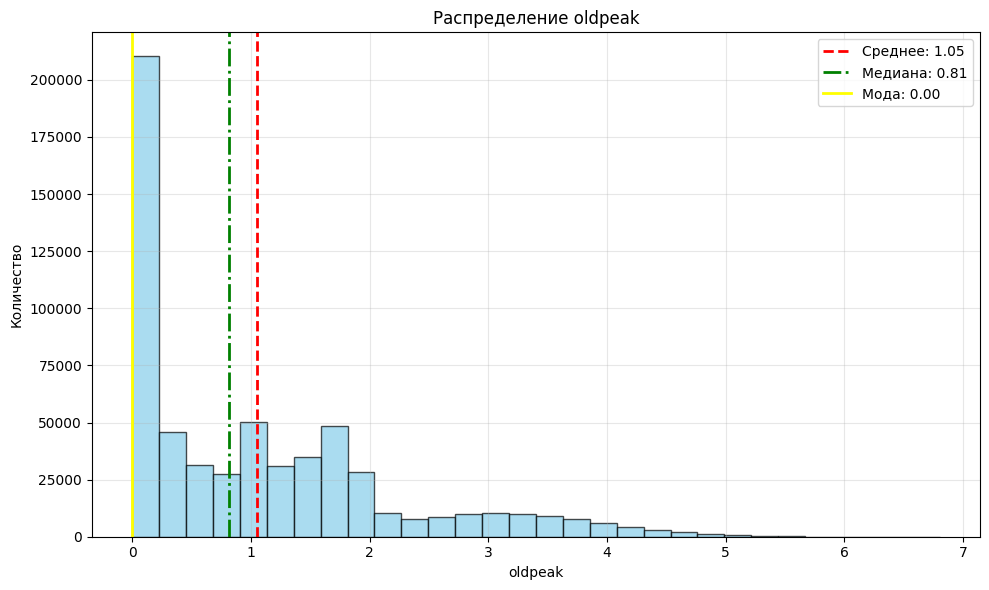

In [404]:
plot_hist(df, 'oldpeak')

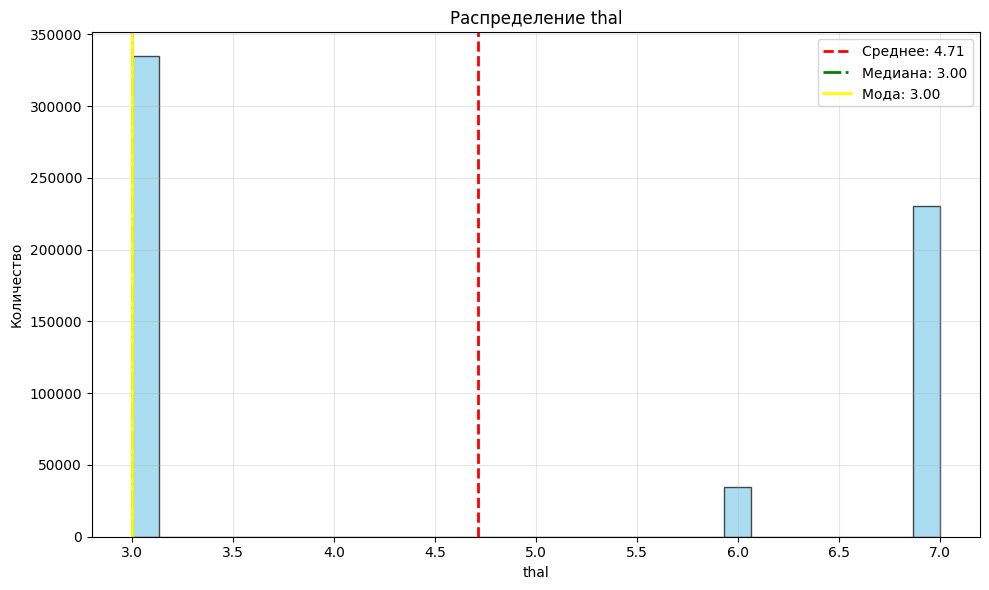

In [405]:
plot_hist(df,'thal')

Распределение thal (3 -   0.557707 7  -  0.384498 6  -  0.057795) медицински некорректно (обратимые эффекты (7) должны встречаться реже фиксированных (6)), что свидетельствует вероятно о перекодировке значений

In [406]:
pd.crosstab(df['thal'],df['class'])

class,0,1
thal,,
3,261497,73127
6,15192,19485
7,56800,173899


In [407]:
df['thal']=df['thal'].replace({6:'temp', 7:6,'temp':7})
df_test['thal']=df_test['thal'].replace({6:'temp', 7:6,'temp':7})

In [408]:
print(df['thal'].unique())

[3 6 'temp']


In [409]:

df['thal']=df['thal'].replace({'temp':7})
df_test['thal']=df_test['thal'].replace({'temp':7})

/var/folders/3d/dbzkj8ms1dn026hxmxhf_h480000gn/T/ipykernel_2997/2608942128.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['thal']=df['thal'].replace({'temp':7})
/var/folders/3d/dbzkj8ms1dn026hxmxhf_h480000gn/T/ipykernel_2997/2608942128.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['thal']=df_test['thal'].replace({'temp':7})


In [410]:
print(df['thal'].unique())

[3 6 7]


In [411]:
df.head()

,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal,class
0,49.207124,0,4.000000,162.996167,181.108682,0,0,148.227858,1,0.944547,2,0,3,1
1,53.628425,1,1.741596,130.233730,276.474630,0,2,152.917139,0,0.119070,2,0,3,0
2,49.591426,1,4.000000,146.999012,223.300517,1,2,102.352090,1,1.616747,2,2,6,1
3,58.991445,1,4.000000,112.369143,187.245501,0,0,158.164750,1,0.000000,1,1,6,1
4,51.053602,1,1.954609,138.032047,238.482868,0,0,172.540828,0,1.150464,1,1,3,0


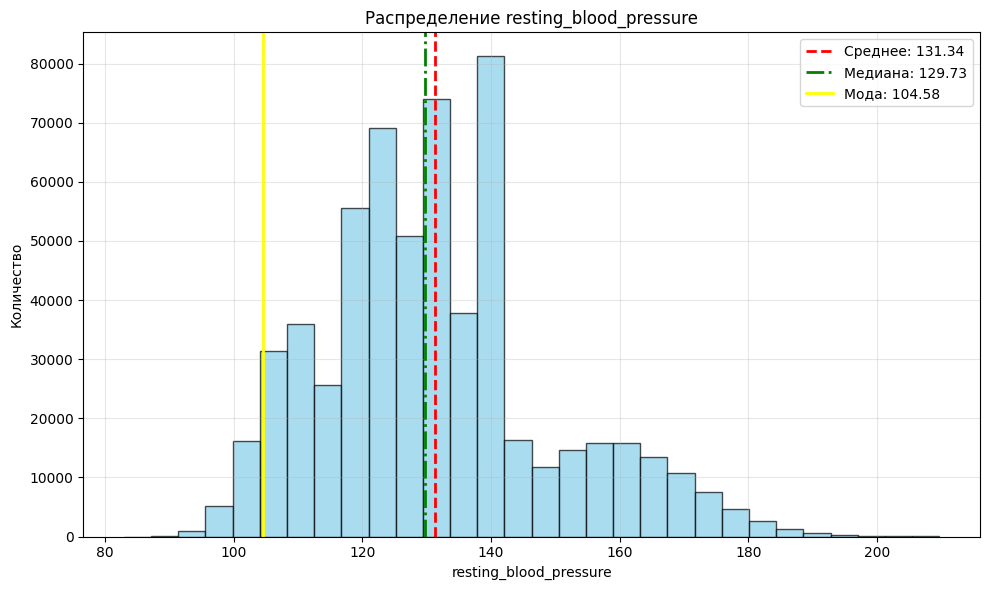

In [412]:
plot_hist(df, 'resting_blood_pressure')

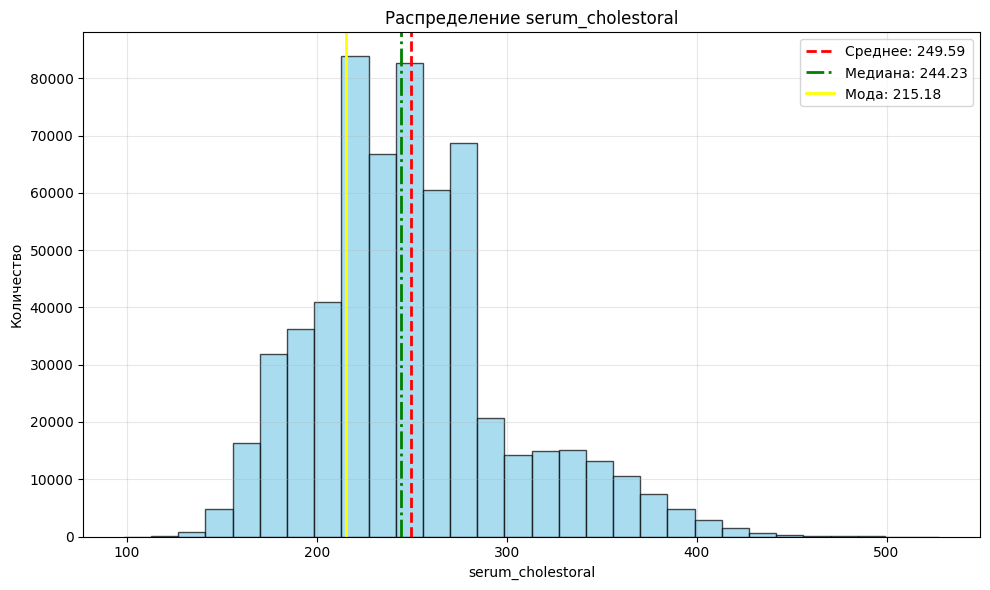

In [413]:
plot_hist(df, 'serum_cholestoral')

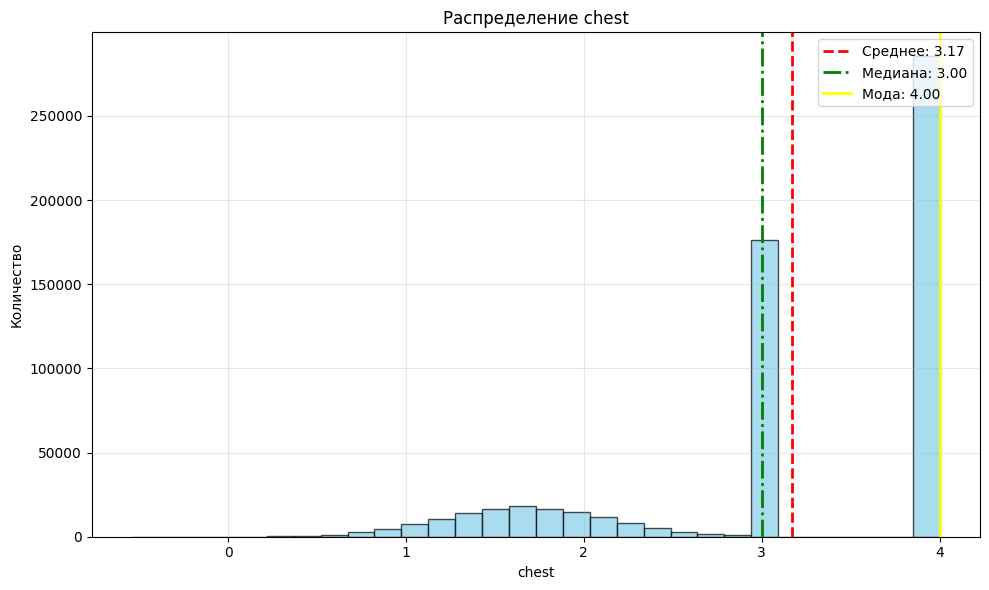

In [414]:
plot_hist(df, 'chest')

Явно выделяются основные категории (3 и 4), которые встречаются чаще всего, а остальные значения можно объединить в категорию other

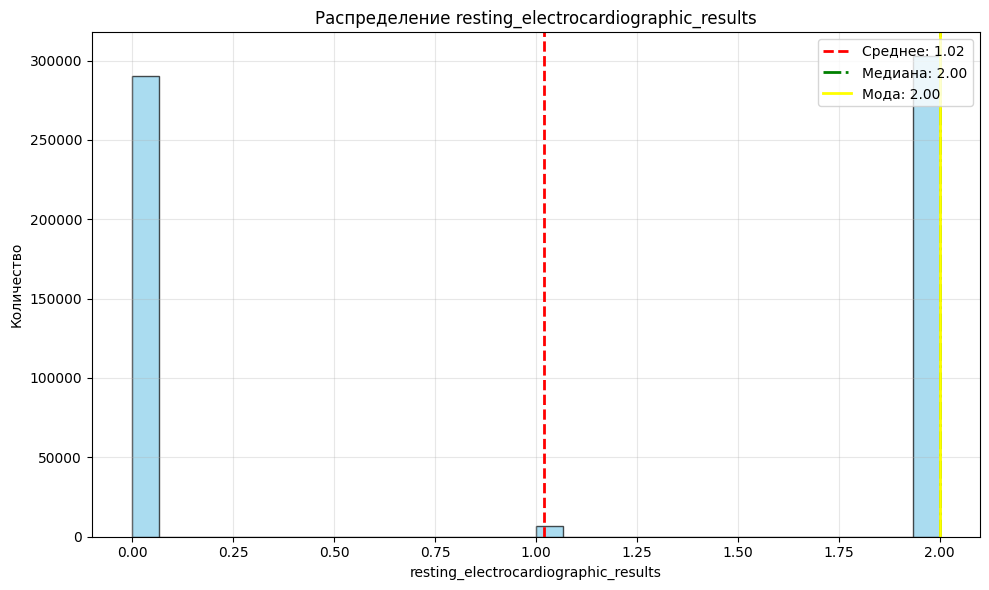

In [415]:
plot_hist(df,'resting_electrocardiographic_results')

Обработка признака chest

In [416]:
main_chest_values = [4.0, 3.0]  # Самые частые значения из распределения

df['chest_grouped'] = df['chest'].apply(
    lambda x: f"chest_{int(x)}" if x in main_chest_values else 'chest_other'
)
df_test['chest_grouped'] = df_test['chest'].apply(
    lambda x: f"chest_{int(x)}" if x in main_chest_values else 'chest_other')

print(df['chest_grouped'].value_counts(normalize=True))

chest_grouped
chest_4        0.475573
chest_3        0.293622
chest_other    0.230805
Name: proportion, dtype: float64


/var/folders/3d/dbzkj8ms1dn026hxmxhf_h480000gn/T/ipykernel_2997/1125870917.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


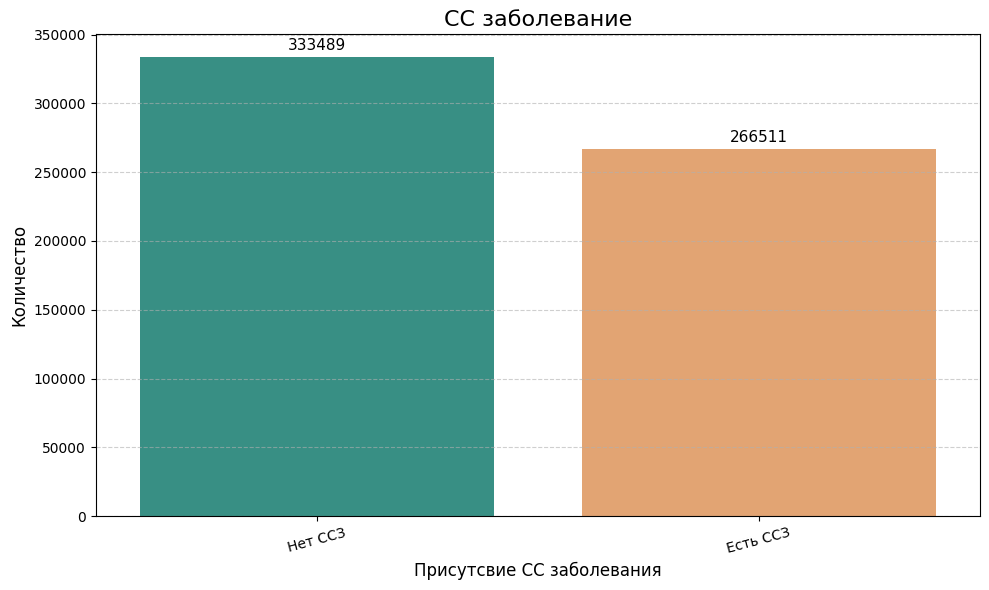

In [417]:
# Словарь для отображения (степени тяжести сердечных заболеваний)
num_labels = {
    0: 'Нет ССЗ',
    1: 'Есть ССЗ'
}

# Маппим и считаем без изменения df
mapped = df['class'].map(num_labels)
num_counts = mapped.value_counts().reset_index()
num_counts.columns = ['Heart Disease Level', 'Count']

# Цвета для столбцов
colors = ['#2a9d8f', '#f4a261']

# Строим график
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='Heart Disease Level',
    y='Count',
    data=num_counts,
    palette=colors
)

# Добавляем подписи с количеством поверх столбцов
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=11, padding=3)

# Финальные штрихи
plt.title('СС заболевание', fontsize=16)
plt.xlabel('Присутсвие СС заболевания', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Промежуточные выводы
- Гистограммы и boxplot показали распределение и наличие выбросов в числовых признаках.
Обнаружены выбросы в признаках: `age` (23), `resting_blood_pressure` (21,129), `serum_cholesterol` (24,342), `maximum_heart_rate_achieved` (3,316), `oldpeak` (9,533)
Визуализация выбросов показала, что не требуется активной очистки данных, поскольку:
* выбросы могут отражать реальные патологические состояния пациентов
* требуется сохранение информации (удаление 3-4% данных (особенно в RBP и cholesterol) привело бы к потере клинически важных случаев
- Проведена частичная обработка для `oldpeak`: отрицательные значения (невозможные физиологически) заменены на 0
- Группировка `chest`: Объединены редкие категории в "chest_other"

Дополнительные инсайты:

* График `oldpeak` (депрессия сегмента ST) показал, что у пациентов с заболеваниями сердца (`class=1`) этот показатель выше
* Распределение заболеваний сердца: 266,511 пациентов с ССЗ и 333,489 без - классы несбалансированы. Соотношение классов 56% (0) / 44% (1) - умеренный дисбаланс

In [418]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


Работа с признаками

In [419]:
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    OrdinalEncoder
)

Обработка категориальных признаков

In [420]:
nominal_features=['thal','resting_electrocardiographic_results', 'chest_grouped']
df=pd.get_dummies(df,columns=nominal_features,drop_first=True)
df_test=pd.get_dummies(df_test,columns=nominal_features,drop_first=True)

Кодирование порядкового признака

In [421]:
slope_order = [[1, 2, 3]]  # Явный порядок для slope
encoder=OrdinalEncoder(categories=slope_order)
df['slope'] = encoder.fit_transform(df[['slope']])
df_test['slope'] = encoder.transform(df_test[['slope']])


Бинарные признаки оставляем как есть: sex, fasting_blood_sugar и др.


- Кодирование:
  - One-Hot для номинативных признаков (`thal`, `chest_grouped`)
  - Ordinal для порядкового `slope`

### 2. Стандартизация числовых признаков

In [422]:

scaler = StandardScaler()
num_features=['age', 'maximum_heart_rate_achieved', 'oldpeak','resting_blood_pressure','serum_cholestoral']
df[num_features] = scaler.fit_transform(df[num_features])
df_test[num_features] = scaler.transform(df_test[num_features])


Нормализация:
- StandardScaler применен к числовым признакам: `age`, `resting_blood_pressure`, `serum_cholesterol`, `maximum_heart_rate_achieved`, `oldpeak`

Удаление исходного признака

In [423]:
df=df.drop('chest',axis=1)
df_test=df_test.drop('chest',axis=1)

### 3. Корреляционный анализ


**Корреляционная матрица:**

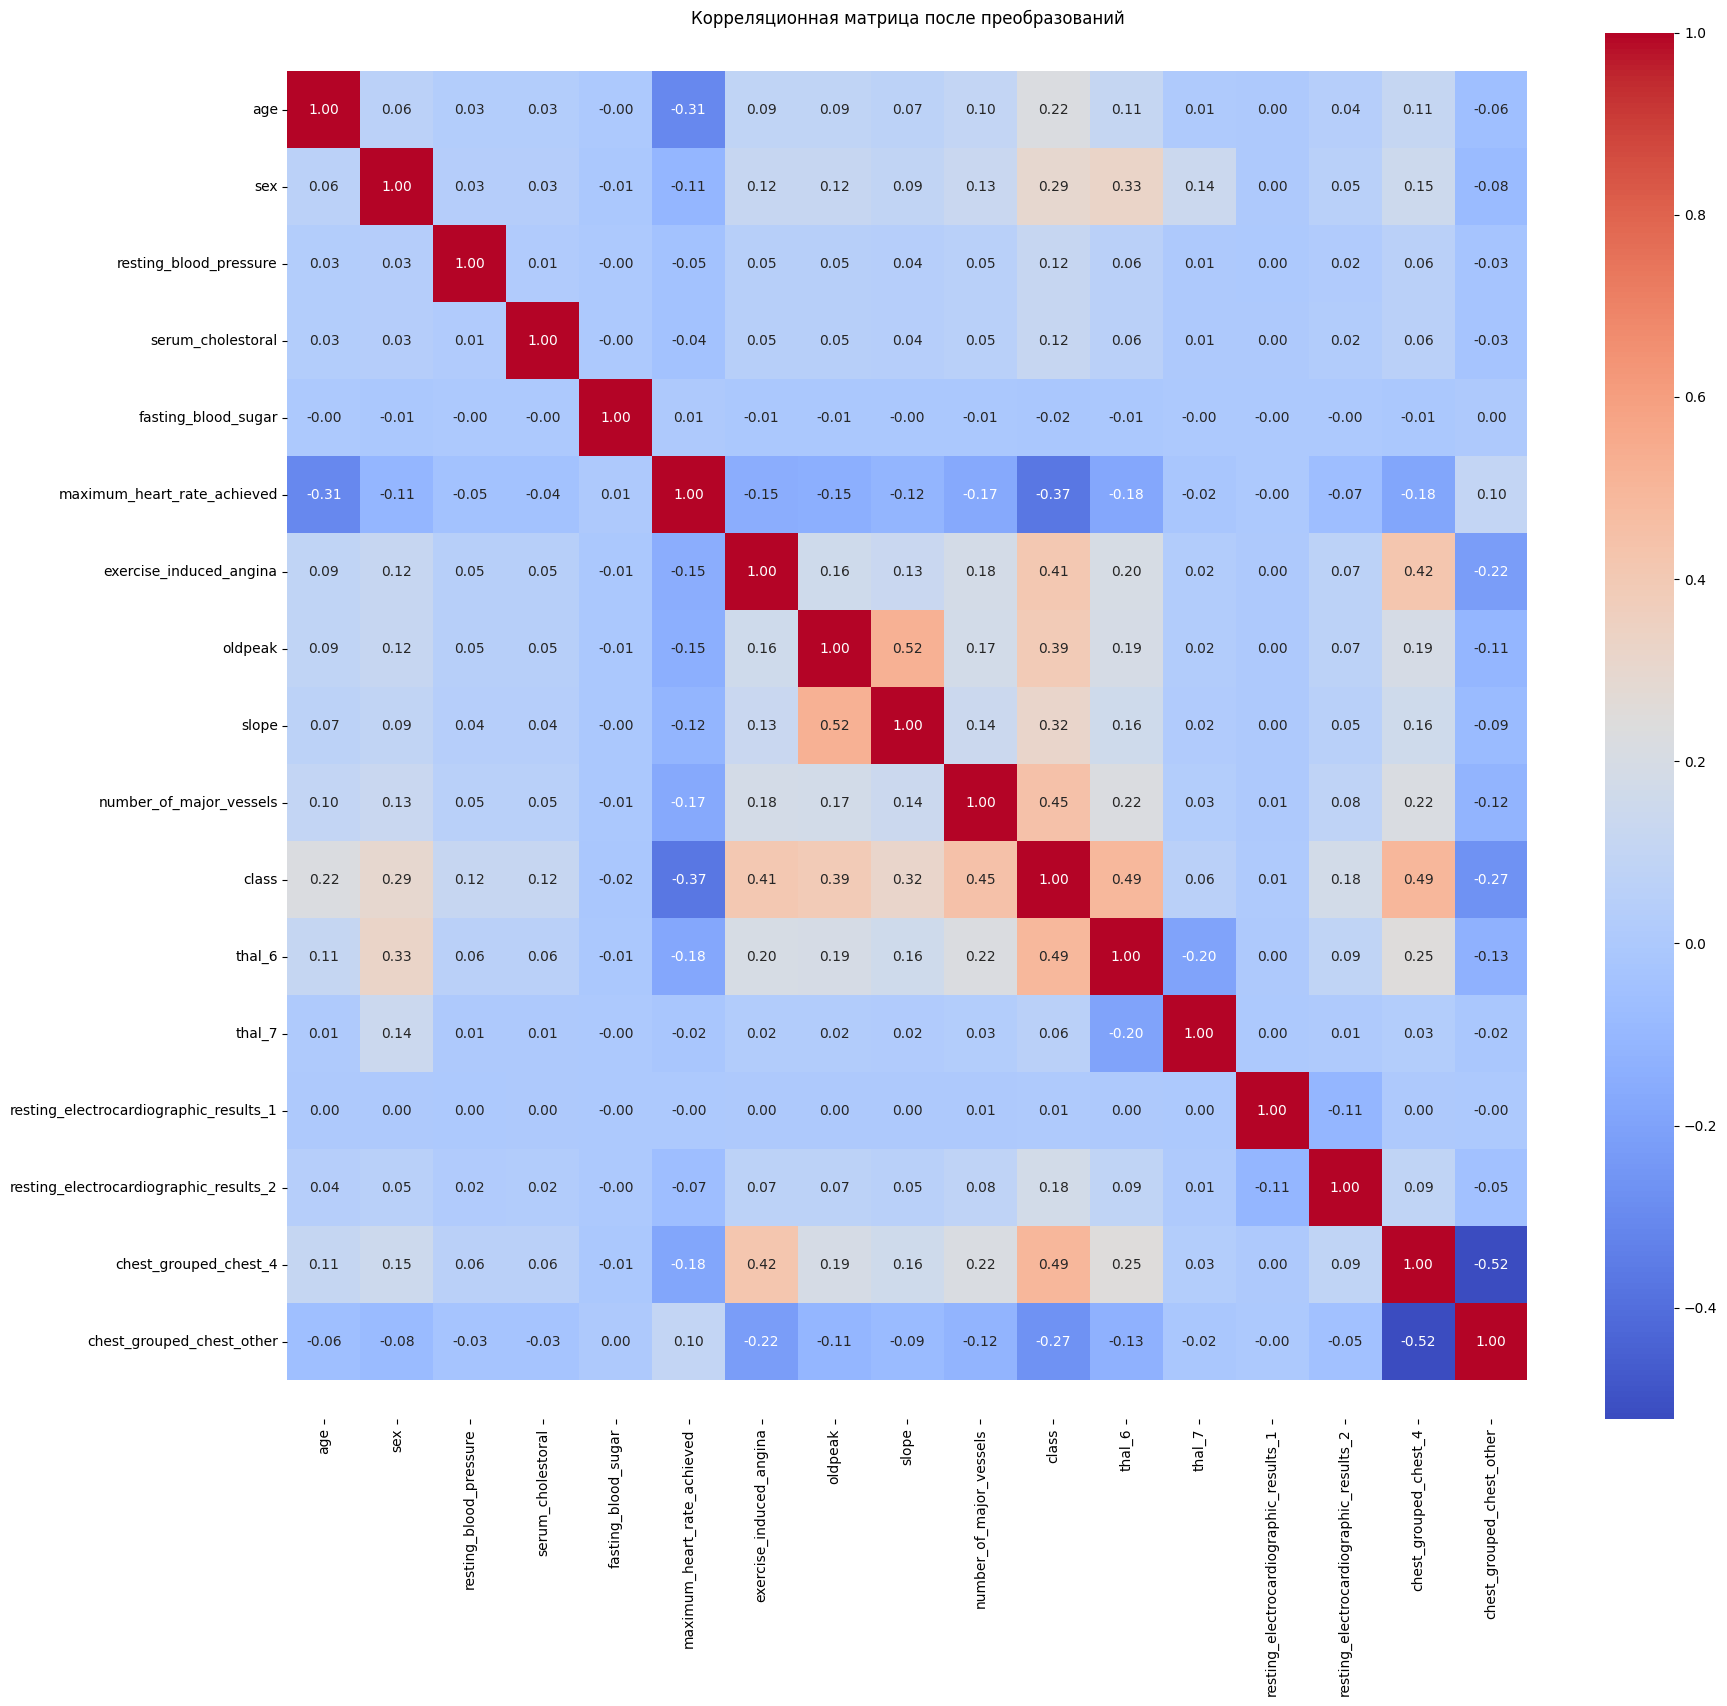

In [424]:

plt.figure(figsize = (20,18))
corr_matrix=df.corr(numeric_only=True)
# heart.corr(numeric_only=True): вычисляет корреляционную матрицу для числовых столбцов DataFrame heart
# annot=True: отображает числовые значения корреляций на тепловой карте
# fmt=".2f": определяет формат числовых значений, отображаемых на тепловой карте (2 знака после запятой)
ax = sns.heatmap(corr_matrix, annot = True, fmt = ".2f",cmap="coolwarm")
# Получаем текущие границы оси Y
i, k = ax.get_ylim()
# Сужаем диапазон оси Y
ax.set_ylim(i+0.5, k-0.5)
plt.title('Корреляционная матрица после преобразований')
plt.show()

In [425]:
corr_with_target = df.corr(numeric_only=True)['class'].abs().sort_values(ascending=False)
print("Топ-5 признаков по корреляции с целевой переменной:")
print(corr_with_target.head(5))

Топ-5 признаков по корреляции с целевой переменной:
class                      1.000000
chest_grouped_chest_4      0.494978
thal_6                     0.492488
number_of_major_vessels    0.447143
exercise_induced_angina    0.411014
Name: class, dtype: float64


Корреляция с целевым признаком:

Самые сильные положительные корреляции: 
- `thal6` (таллиевый стресс-тест), `chest_grouped_chest_4`,`exercise_induced_angina`, `number_of_major_vessels`

Самые сильные отрицательные корреляции: 
- `maximum_heart_rate_achieved`, `slope`

Умеренная положительная корреляция с болезнью сердца:
- `age` 

Мультиколлинеарность:

Высокая корреляция между:
  - `age` и `maximum_heart_rate_achieved` (отрицательная, r ≈ -0.4)
  - `resting_blood_pressure` и `age` (положительная, r ≈ 0.3-0.4)
  - `serum_cholesterol` и `age` (положительная, r ≈ 0.25-0.35)

Неинформативные признаки:
- `fasting_blood_sugar` имеет почти нулевую корреляцию с целевой переменной
- `resting_electrocardiographic_results_1` показывает минимальную корреляцию


Удаление неинформативных признаков

In [426]:
to_drop = [
    'fasting_blood_sugar', 
    'resting_electrocardiographic_results_1'
]

In [427]:
df = df.drop(columns=to_drop)
df_test = df_test.drop(columns=to_drop)

In [428]:
print(f"Осталось признаков: {df.shape[1]}")
print("Оставшиеся признаки:", df.columns.tolist())

Осталось признаков: 15
Оставшиеся признаки: ['age', 'sex', 'resting_blood_pressure', 'serum_cholestoral', 'maximum_heart_rate_achieved', 'exercise_induced_angina', 'oldpeak', 'slope', 'number_of_major_vessels', 'class', 'thal_6', 'thal_7', 'resting_electrocardiographic_results_2', 'chest_grouped_chest_4', 'chest_grouped_chest_other']


Импорт библиотек для обучения моделей

In [429]:

from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
)

from sklearn.model_selection import (
    StratifiedKFold,
    cross_validate,
    cross_val_score,
    KFold
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    multilabel_confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve,
    average_precision_score,
    precision_recall_curve
)

from sklearn.tree import plot_tree  # Функция для визуализации структуры дерева решений

from scipy.stats import (           # Модули для работы с распределениями, позволяющие генерировать
    uniform,                        # выборки из равномерного
    randint                         # и дискретного равномерного распределений
)

# Функция для оценки важности признаков, основанная на изменении точности модели при перестановке значений признаков
from sklearn.inspection import permutation_importance

### 4. **Обучение моделей:**


In [430]:
X_train_full=df.drop(["class"], axis=1)
y_train_full=df['class']
X_final_test=df_test

In [431]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=y_train_full
)

### Обучение модели логистической регрессии

In [432]:
logreg_model = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)
val_predictions = logreg_model.predict(X_val) 
val_proba=logreg_model.predict_proba(X_val) 
test_predictions = logreg_model.predict(df_test)

In [433]:
print("Метрики для логистической регрессии на валидационной выборке")
print(classification_report(y_val,val_predictions))
print(F"ROC-AUC:{roc_auc_score(y_val,val_proba[:,1]):.4f}")

Метрики для логистической регрессии на валидационной выборке
              precision    recall  f1-score   support

           0       0.89      0.90      0.90     66698
           1       0.88      0.86      0.87     53302

    accuracy                           0.88    120000
   macro avg       0.88      0.88      0.88    120000
weighted avg       0.88      0.88      0.88    120000

ROC-AUC:0.9516


**Logistic Regression**:
   - Показала хорошие результаты (Accuracy: 0.88, ROC-AUC: 0.9516).

In [434]:
# Определим функцию plot_imp, которая принимает два аргумента: features и importance.
# Аргументы функции - это списки или массивы, которые будут использоваться для построения графика:
def plot_imp(features, importance):
# Создадим список order, который содержит индексы элементов массива importance, упорядоченных по убыванию.
# Функция argsort из библиотеки NumPy используется для сортировки массивов:
    order = np.argsort(importance)
# Присвом переменным features и importance новый список, который содержит элементы исходного списка arteria,importance
# упорядоченные в соответствии с порядком, определенным в order:
    features = features[order]
    importance = importance[order]

    for idx, val in enumerate(importance):
        print(f'{features[idx]:40} {val:.4f}')
    plt.figure(figsize=(4, np.ceil(len(features) / 4)))

    plt.barh(features, importance) # рисует гистограмму
    plt.show() # отображает график на экране

In [435]:
importance_logreg=logreg_model.coef_[0]

maximum_heart_rate_achieved              -0.7308
chest_grouped_chest_other                -0.1198
resting_blood_pressure                   0.2319
serum_cholestoral                        0.2401
age                                      0.2875
slope                                    0.5076
resting_electrocardiographic_results_2   0.7201
sex                                      0.7296
oldpeak                                  0.7408
number_of_major_vessels                  1.0848
thal_7                                   1.2447
exercise_induced_angina                  1.2947
chest_grouped_chest_4                    1.7545
thal_6                                   2.1721


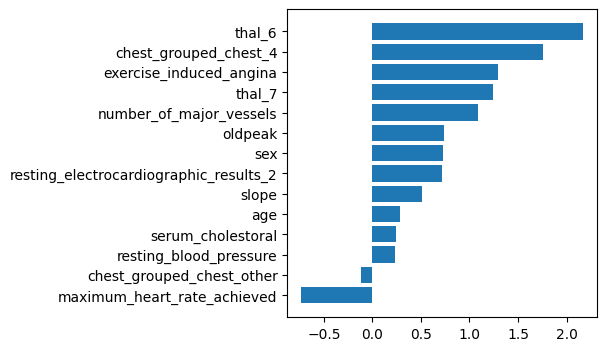

chest_grouped_chest_other                0.1198
resting_blood_pressure                   0.2319
serum_cholestoral                        0.2401
age                                      0.2875
slope                                    0.5076
resting_electrocardiographic_results_2   0.7201
sex                                      0.7296
maximum_heart_rate_achieved              0.7308
oldpeak                                  0.7408
number_of_major_vessels                  1.0848
thal_7                                   1.2447
exercise_induced_angina                  1.2947
chest_grouped_chest_4                    1.7545
thal_6                                   2.1721


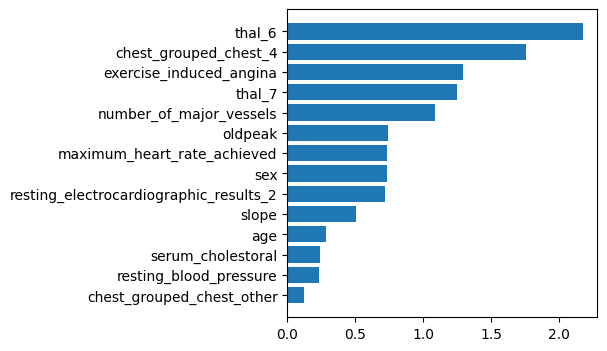

In [436]:
features1 = X_train_full.columns
plot_imp(features1, importance_logreg)
plot_imp(features1, np.abs(importance_logreg))

Для прогнозирования сердечно-сосудистого риска наиболее важными признаками определены 
- thal 6 - обратимый дефект при таллиевом стресс-тесте - отражает патологию, критичную для диагностики.
- сhest_grouped_chest_4(атипичная боль в груди), который является субЪективным симптомом. 
- number_of_major_vessels (количество сосудов) и exercise_induced_angina (стенокардия при нагрузке) 

Также выявлен негативный индикатор - максимальная ЧСС (`maximum_heart_rate_achieved`) - чем выше ЧСС, тем ниже риск.

Модель может быть полезна для прогнозирования ССЗ у бессимптомных пациентов

In [437]:
test_preds=logreg_model.predict(X_final_test)
test_probs=logreg_model.predict_proba(X_final_test)[:,1]

### Обучение модели рандомного леса

In [438]:
model = RandomForestClassifier(random_state=42, n_jobs=-1)
model= model.fit(X_train, y_train)
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)
train_probs = model.predict_proba(X_train)[:, 1]
val_probs = model.predict_proba(X_val)[:, 1]

In [439]:
def specificity(y_true, preds):
    # Вычисляем специфичность
    tn = np.sum((y_true == 0) & (preds == 0))  # Истинно отрицательные
    fp = np.sum((y_true == 0) & (preds == 1))  # Ложно положительные
    return tn / (tn + fp) if (tn + fp) > 0 else 0

In [440]:
def evaluate_model(X_train, X_val, y_train, y_val, train_preds, val_preds, train_probs, val_probs):
    # Определяем метрики и соответствующие функции из sklearn
    metric_functions = {
        'Accuracy (достоверность)': (metrics.accuracy_score, {}),
        'Balanced Accuracy (сбалансированная достоверность)': (metrics.balanced_accuracy_score, {}),
        'Precision (точность)': (metrics.precision_score, {'average': 'weighted'}),
        'Recall (полнота)': (metrics.recall_score, {}),
        'F1 score (F1-мера)': (metrics.f1_score, {'average': 'weighted'}),
        'Specificity (специфичность)': (specificity, {'y_true': y_train, 'preds': train_preds}),
        'ROC AUC': (metrics.roc_auc_score, {}),
        'PR AUC': (metrics.average_precision_score, {})
    }

    # Цикл по наборам и метрикам
    for dataset_name, (y_true, preds, probs) in zip(['тренировочной', 'валидационной'],
                                                      [(y_train, train_preds, train_probs),
                                                       (y_val, val_preds, val_probs)]):
        print(f'Метрики на {dataset_name} выборке:')
        for metric_name, (metric_func, kwargs) in metric_functions.items():
            if metric_name in ['ROC AUC', 'PR AUC']:
                score = metric_func(y_true, probs)
            elif metric_name == 'Specificity (специфичность)':
                score = metric_func(y_true, preds)
            else:
                score = metric_func(y_true, preds, **kwargs)
            print(f'{metric_name}: {score:.4f}')
        print()  # Пустая строка для разделения выводов

In [441]:
evaluate_model(X_train, X_val, y_train, y_val, train_preds, val_preds, train_probs, val_probs)

Метрики на тренировочной выборке:
Accuracy (достоверность): 1.0000
Balanced Accuracy (сбалансированная достоверность): 1.0000
Precision (точность): 1.0000
Recall (полнота): 0.9999
F1 score (F1-мера): 1.0000
Specificity (специфичность): 1.0000
ROC AUC: 1.0000
PR AUC: 1.0000

Метрики на валидационной выборке:
Accuracy (достоверность): 0.8972
Balanced Accuracy (сбалансированная достоверность): 0.8950
Precision (точность): 0.8972
Recall (полнота): 0.8748
F1 score (F1-мера): 0.8971
Specificity (специфичность): 0.9152
ROC AUC: 0.9598
PR AUC: 0.9518



**Переобучение Random Forest**: Train Accuracy = 1.0 vs Test Accuracy = 0.897


Предсказание на отдельном тестовом наборе

In [442]:
test_preds=model.predict(X_final_test)
test_probs=model.predict_proba(X_final_test)[:,1]

### Метод борьбы с дисбалансом классов:

 Изменение "веса" объектов разного класса.

В sklearn чтобы модель учла дисбаланс классов можно указать гиперпараметр `class_weight='balanced'` и obb_score для валидации без отдельного валидационного набора

In [443]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=1000, oob_score=True,
                                    class_weight='balanced')
model= model.fit(X_train, y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_val)
train_probs = model.predict_proba(X_train)[:, 1]
test_probs = model.predict_proba(X_val)[:, 1]

In [444]:
print(f'Balanced Accuracy on oob   {balanced_accuracy_score(y_train, model.oob_decision_function_[:, 1] >= 0.5):.5f}')

Balanced Accuracy on oob   0.89600


In [445]:
evaluate_model(X_train, X_val, y_train, y_val, train_preds, test_preds, train_probs, test_probs)

Метрики на тренировочной выборке:
Accuracy (достоверность): 1.0000
Balanced Accuracy (сбалансированная достоверность): 1.0000
Precision (точность): 1.0000
Recall (полнота): 1.0000
F1 score (F1-мера): 1.0000
Specificity (специфичность): 1.0000
ROC AUC: 1.0000
PR AUC: 1.0000

Метрики на валидационной выборке:
Accuracy (достоверность): 0.8978
Balanced Accuracy (сбалансированная достоверность): 0.8955
Precision (точность): 0.8977
Recall (полнота): 0.8756
F1 score (F1-мера): 0.8977
Specificity (специфичность): 0.9155
ROC AUC: 0.9610
PR AUC: 0.9547



**Random Forest**:
   - Лучшие результаты (Accuracy: 0.897, ROC-AUC: 0.9604).
   - Хорошо справляется с нелинейными зависимостями и выбросами.
   - Переобучение: Accuracy на тренировочных данных = 1.0, на валидационных = 0.897.

#### Важность признаков 


                                   Feature  Importance
9                                   thal_6    0.135014
12                   chest_grouped_chest_4    0.126901
8                  number_of_major_vessels    0.123653
4              maximum_heart_rate_achieved    0.116609
6                                  oldpeak    0.099396
0                                      age    0.090337
3                        serum_cholestoral    0.065508
5                  exercise_induced_angina    0.064612
2                   resting_blood_pressure    0.063451
7                                    slope    0.058466
1                                      sex    0.025314
13               chest_grouped_chest_other    0.011988
11  resting_electrocardiographic_results_2    0.011436
10                                  thal_7    0.007316


Text(0.5, 1.0, 'Важность признаков RandomForest')

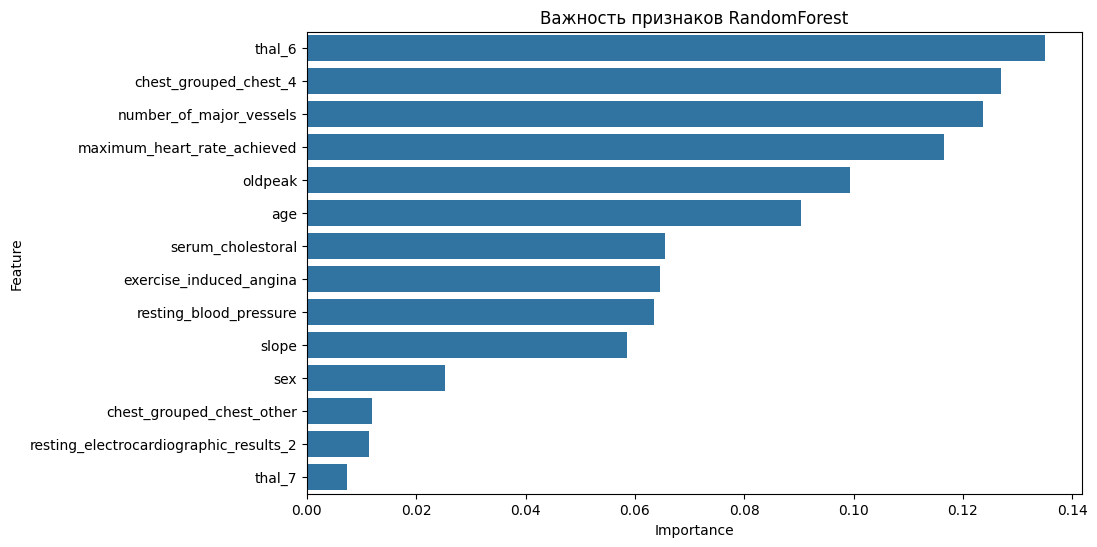

In [446]:
feature_importances = pd.DataFrame({ "Feature": X_train.columns, "Importance": model.feature_importances_ }).sort_values("Importance", ascending=False)
print(feature_importances)
# Визуализация 
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importances)
plt.title("Важность признаков RandomForest")

Для прогнозирования сердечно-сосудистого риска наиболее важными признаками определены:
- thal7 - талиум стресс-тест (фиксированный дефект)
- сhest_grouped_chest_4(атипичная боль в груди), который является субЪективным симптомом. 
- number_of_major_vessels (количество сосудов)
- `maximum_heart_rate_achieved`) (максимальная ЧСС)

Модель может быть полезна для прогнозирования ССЗ у бессимптомных пациентов

Импорт библиотек для подбора гиперпараметров

In [447]:
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV)

# Подбор гиперпараметров

In [448]:
from scipy.stats import randint
def randomized_search(X_train, y_train, model, params, scoring, cv, n_iter=20):
  """Перебор всевозможных гиперпараметров
  Параметры:
  X_train: объекты обучающей выборки
  y_train: значения целевой переменной обучающей выборки
  model: модель, для которой производится подбор гиперпараметров
  params: словарь с названиями гиперпараметрамов и всеми наборами значений
  scoring: функция, которая будет минимизироваться в ходе кросс-валидации (можно передать список метрик)
  cv: количество частей, на которые будет поделена выборка
  Возвращает: наилучшие гиперпараметры
  """
  searcher = RandomizedSearchCV(
      estimator=model,
      param_distributions=params,
      n_iter=5,
      scoring=scoring,
      cv=2,
      n_jobs=2,
      verbose=1, # чтобы выводилось что-то в процессе подбора параметров, необходимо выставить какое-то значение > 0
  )
  searcher.fit(X_train, y_train)
  best_params = searcher.best_params_

  # print("Best hyperparameters:", best_params)
  return best_params

In [449]:
def model_train_test(X_train, y_train, X_val, y_val, model):
    """
    Обучает модель, вычисляет метрики и возвращает результаты.
    
    Параметры:
        X_train, y_train: обучающие данные.
        X_val, y_val: валидационные данные.
        model: модель (например, RandomForestClassifier).
    
    Возвращает:
        pred: предсказания на валидации.
        proba: вероятности классов.
        importance: важность признаков (если есть).
        metrics: словарь с метриками.
    """
    # Обучение модели
    model.fit(X_train, y_train)
    
    # Предсказания
    pred = model.predict(X_val)
    proba = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Важность признаков (для Random Forest)
    importance = (
        model.feature_importances_ 
        if hasattr(model, "feature_importances_") 
        else None
    )
    
    # Метрики
    metrics = {
        "accuracy": accuracy_score(y_val, pred),
        "roc_auc": roc_auc_score(y_val, proba) if proba is not None else None,
        "f1": f1_score(y_val, pred),
        "precision": precision_score(y_val, pred),
        "recall": recall_score(y_val, pred),
    }
    
    return pred, proba, importance, metrics

In [450]:

def find_and_train_test_best_params(
    X_train, y_train,
    params, scoring, cv,
    X_val, y_val,
    model_class
):
    print(str(model_class.__name__))
    best_params = randomized_search(X_train, y_train, model_class(), params, scoring, cv)
    print("Лучшие параметры:", best_params)
    best_model=model_class(**best_params)
    pred, proba, importance, metrics = model_train_test(X_train, y_train, X_val, y_val, best_model)
    return best_model, best_params, pred, metrics

Проведем подбор гиперпараметров и сравним новые результаты. Для начала зафиксируем параметры функций, которые не будут меняться:

In [451]:
CONFIG_CV = {
    "cv": 5,
    "scoring": "f1", # подбирать гиперпараметры будем по F1-мере
}

In [452]:
%%time
# чтобы посмотреть, сколько по времени выполняется ячейка

rf_params_rs = {
    "n_estimators": [50, 100],
    "max_depth": [10, 20],
    "min_samples_split": [2,5],
    "random_state": [42]
}

model_rf, best_params_rf, preds_rf, metrics_rf = find_and_train_test_best_params(
    X_train=X_train,
    y_train=y_train,
    params=rf_params_rs,
    scoring=CONFIG_CV['scoring'],
    cv=CONFIG_CV['cv'],
    X_val=X_val,
    y_val=y_val,
    model_class=RandomForestClassifier,
)

RandomForestClassifier
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Лучшие параметры: {'random_state': 42, 'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 20}
CPU times: user 2min 4s, sys: 777 ms, total: 2min 5s
Wall time: 3min 49s


In [453]:
# Для лучшей модели RandomForest после подбора гиперпараметров
train_preds = model_rf.predict(X_train)
val_preds = model_rf.predict(X_val)

print("Метрики на обучающей выборке:")
print(classification_report(y_train, train_preds))
print(f"ROC-AUC: {roc_auc_score(y_train, train_preds):.4f}")

print("\nМетрики на валидационной выборке:")
print(classification_report(y_val, val_preds))
print(f"ROC-AUC: {roc_auc_score(y_val, val_preds):.4f}")

# Расчет разницы в accuracy
train_acc = accuracy_score(y_train, train_preds)
val_acc = accuracy_score(y_val, val_preds)
print(f"\nРазница accuracy: {abs(train_acc - val_acc):.4f}")


Метрики на обучающей выборке:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97    266791
           1       0.97      0.96      0.96    213209

    accuracy                           0.97    480000
   macro avg       0.97      0.97      0.97    480000
weighted avg       0.97      0.97      0.97    480000

ROC-AUC: 0.9659

Метрики на валидационной выборке:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     66698
           1       0.89      0.88      0.88     53302

    accuracy                           0.90    120000
   macro avg       0.90      0.90      0.90    120000
weighted avg       0.90      0.90      0.90    120000

ROC-AUC: 0.8959

Разница accuracy: 0.0691


Установка библиотеки tensorflow

In [454]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [455]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
import matplotlib.pyplot as plt

### 1. Подготовка данных

In [456]:
X = df.drop('class', axis=1).values.astype(np.float32)
y = df['class'].values.astype(np.float32)

### Разделение на тренировочную и тестовую выборки

In [457]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)


### 2. Создание модели 

In [470]:
def create_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            AUC(name='auc'),
            Precision(name='precision'),
            Recall(name='recall')
        ]
    )
    return model

input_dim = X_train.shape[1]
model = create_model(input_dim)

/Users/macbook/Documents/Skillfactory/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 3. Колбэки для контроля обучения

In [478]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    save_best_only=True,
    monitor='val_auc',
    mode='max'
)


### 4. Обучение модели

In [479]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=1024,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint],
    class_weight={0: 1, 1: len(y_train)/sum(y_train)-1}  # Балансировка классов
)

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8969 - auc: 0.9606 - loss: 0.2819 - precision: 0.8780 - recall: 0.8910 - val_accuracy: 0.8999 - val_auc: 0.9633 - val_loss: 0.2438 - val_precision: 0.8872 - val_recall: 0.8890
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8971 - auc: 0.9608 - loss: 0.2812 - precision: 0.8779 - recall: 0.8916 - val_accuracy: 0.8996 - val_auc: 0.9632 - val_loss: 0.2436 - val_precision: 0.8894 - val_recall: 0.8854
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8977 - auc: 0.9613 - loss: 0.2798 - precision: 0.8795 - recall: 0.8918 - val_accuracy: 0.8998 - val_auc: 0.9633 - val_loss: 0.2435 - val_precision: 0.8879 - val_recall: 0.8880
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8972 - auc: 0.9612 - loss: 0.2802 - precision: 0.8780 - recall: 0.8925 - val_accuracy: 0.9000 - val_auc: 0.9633 - val_loss: 0.2438 - val_precision: 0.8873 - val_recall: 0.8892
Epoch 5/100
375/375 ━━━━━━━━

# 5. Визуализация истории обучения 

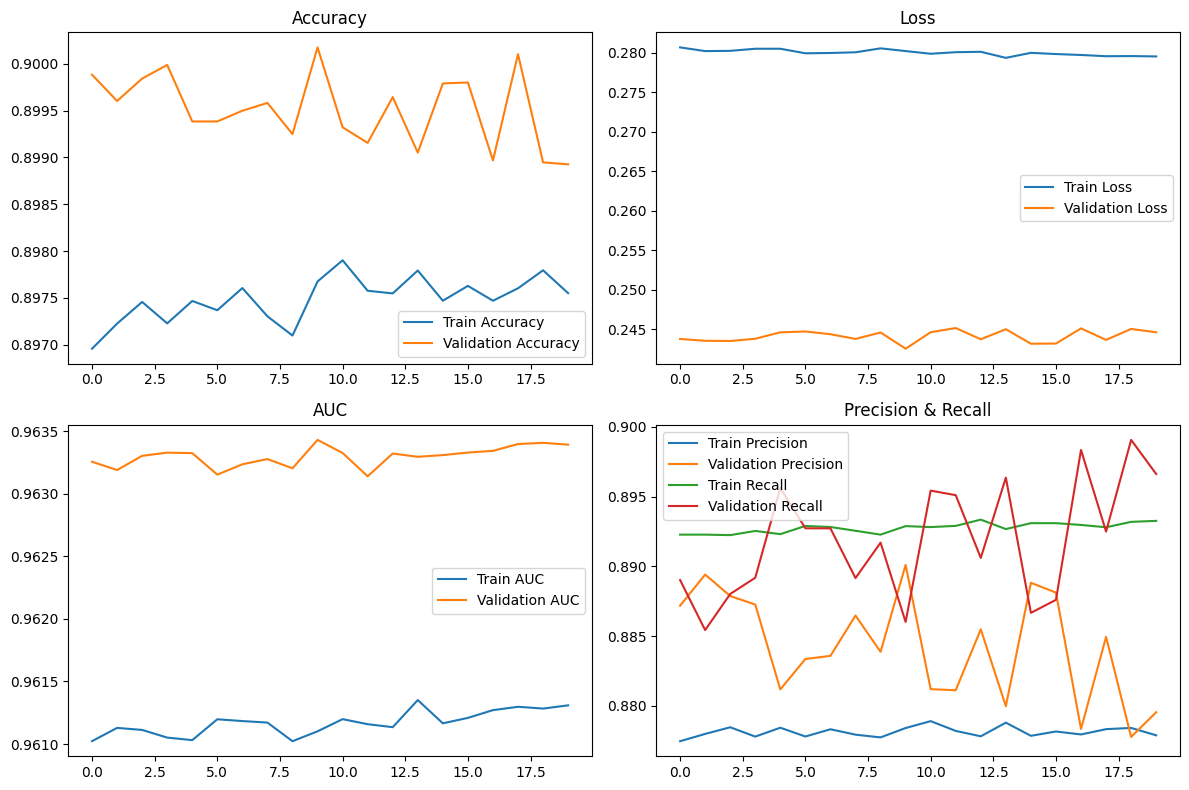

In [480]:
def plot_history(history):
    plt.figure(figsize=(12, 8))
    
    # Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    
    # AUC
    plt.subplot(2, 2, 3)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('AUC')
    plt.legend()
    
    # Precision-Recall
    plt.subplot(2, 2, 4)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.title('Precision & Recall')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)

In [481]:
# 6. Оценка на валидационных данных
val_results = model.evaluate(X_val, y_val, verbose=0)
val_predictions = (model.predict(X_val) > 0.5).astype(int).flatten()

# 7. Генерация отчета
print("\nVal Evaluation:")
print(f"Accuracy: {val_results[1]:.4f}")
print(f"AUC: {val_results[2]:.4f}")
print(f"Precision: {val_results[3]:.4f}")
print(f"Recall: {val_results[4]:.4f}")
print(f"F1-Score: {2 * (val_results[3] * val_results[4]) / (val_results[3] + val_results[4]):.4f}")

print("\nClassification Report:")
print(classification_report(y_val, val_predictions))

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1s 279us/step

Val Evaluation:
Accuracy: 0.8999
AUC: 0.9632
Precision: 0.8872
Recall: 0.8874
F1-Score: 0.8873

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91     66698
         1.0       0.89      0.89      0.89     53302

    accuracy                           0.90    120000
   macro avg       0.90      0.90      0.90    120000
weighted avg       0.90      0.90      0.90    120000



### **Neural Network**:
   - Наилучшие результаты (Accuracy: 0.8993, ROC-AUC: 0.9631).

#### 8. Прогнозирование на финальном тестовом наборе

In [482]:
final_test_predictions = (model.predict(X_final_test) > 0.5).astype(int).flatten()
final_test_probs= model.predict(X_final_test).flatten()

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 4s 280us/step
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 3s 265us/step


### Общие результаты

In [483]:
y_pred=(model.predict(X_val)>0.5).astype(int).flatten()

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1s 278us/step


/Users/macbook/Documents/Skillfactory/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/macbook/Documents/Skillfactory/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/macbook/Documents/Skillfactory/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/macbook/Documents/Skillfactory/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1s 264us/step
                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Logistic Regression  0.882692   0.876403  0.856722  0.866451  0.951633
1        Random Forest  0.898025   0.892133  0.876384  0.884188  0.961182
2       Neural Network  0.899325   0.884560  0.889423  0.886985  0.963132


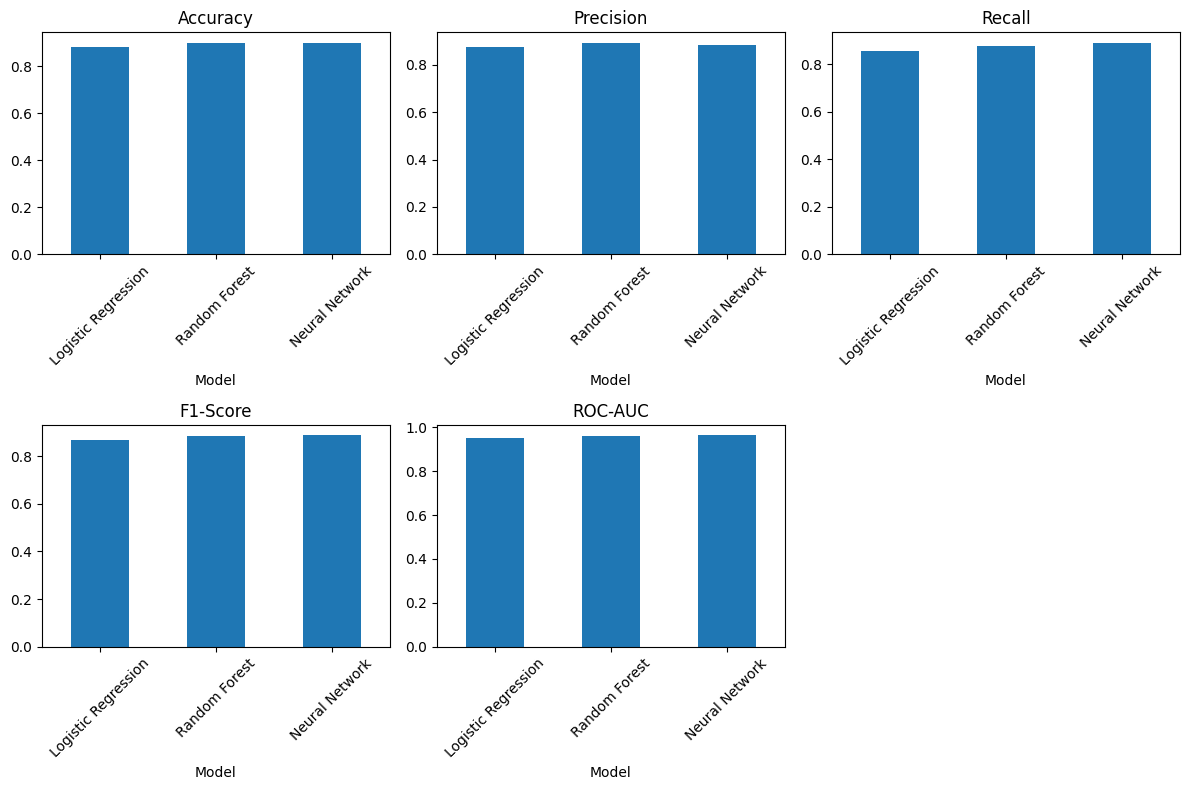

In [477]:
def evaluate_model(model, X_test, y_test, model_name):
    if isinstance(model,Sequential):
        y_proba = model.predict(X_test).flatten()
        y_pred = (y_proba>0.5).astype(int)
    else:
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
         'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else "N/A"
    }
    return metrics

# Сравнение всех моделей
models = {
    'Logistic Regression': logreg_model,
    'Random Forest': model_rf, # Лучшая версия Random Forest после подбора параметров
    'Neural Network': model # TensorFlow/Keras модель (предварительно сохраненная)
}

results = []
for name, model in models.items():
    results.append(evaluate_model(model, X_val, y_val, name))

# Создание DataFrame с результатами
df_results = pd.DataFrame(results)
print(df_results)

# Визуализация
plt.figure(figsize=(12, 8))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 3, i+1)
    df_results.plot.bar(x='Model', y=metric, ax=plt.gca(), legend=False)
    plt.title(metric)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# выводы

1) Обработка данных:
* выбросы могут отражать реальные патологические состояния пациентов
* требуется сохранение информации (удаление 3-4% данных (особенно в RBP и cholesterol) привело бы к потере клинически важных случаев
* проведена частичная обработка для `oldpeak`: отрицательные значения (невозможные физиологически) заменены на 0
* группировка `chest`: объединены редкие категории в "chest_other"
* перекодировка таллиум стресс-теста (6 на 7)
2) Корреляции.
3) Для прогнозирования сердечно-сосудистого риска наиболее важными признаками определены:
- thal6 - таллиум стресс-тест (фиксированный дефект): ключевой индикатор ишемии миокарда
- сhest_grouped_chest_4(атипичная боль в груди)
- number_of_major_vessels (количество сосудов)
- maximum_heart_rate_achieved (максимальная ЧСС) (обратная зависимость) - низкая ЧСС - признак ишемии

! Модель может быть полезна для прогнозирования ССЗ у бессимптомных пациентов

4) Балансировка классов:
- Соотношение классов 56% (0) / 44% (1) - умеренный дисбаланс
- Использованы методы:
  - class_weight='balanced' в Random Forest
  - Ручная балансировка весов в нейронной сети

5. Обучение моделей

| Модель               | Точность | Точность (Precision) | Полнота (Recall) | F1-мера | ROC-AUC |
|---------------------|----------|-----------|--------|----------|---------|
| Логистическая регрессия | 0.880    | 0.880     | 0.860  | 0.870    | 0.952   |
| Случайный лес       | 0.897    | 0.898     | 0.876  | 0.887    | 0.960   |
| Нейронная сеть      | 0.899    | 0.885     | 0.889  | 0.887    | 0.963   |

**Лучшая модель**: Нейронная сеть показала наивысшую точность (0.899) и ROC-AUC (0.963).

- **Лучшая модель**: Нейронная сеть показала наилучшие метрики, но Random Forest близок по эффективности и проще в интерпретации.

- Данные согласуются с данными  литературы (см. ниже)

An artificial intelligence model for heart disease detection using machine learning algorithms
Author: 
Victor Chang,Vallabhanent Rupa Bhavani,Ariel Qianwen Xu,MA Hossain
Publication: 
Healthcare Analytics
Publisher: 
Elsevier
Date: 
November 2022
© 2022 The Author(s). Published by Elsevier Inc.

Краткое резюме

Статья посвящена разработке приложения для обнаружения сердечно-сосудистых заболеваний с использованием технологий искусственного интеллекта и машинного обучения на базе языка программирования Python.
Выбор языка Python авторы обосновывают соответствием стандарту HIPAA для защиты медицинских данных, множеством библиотек для анализа данных и ML, простотой синтаксиса и поддержкой визуализации (тепловые карты корреляции, гистограммы).
Авторы исследуют возможности различных алгоритмов классификации, таких как логистическая регрессия, метод опорных векторов и случайный лес, применяя их к медицинским данным пациентов. 
В данной публикации использован датасет из 314 записей с 14 признаками (100 записей использовано для тестирования). Признаки включают: возраст, пол, тип боли в груди (cp), уровень холестерина (chol), давление (trestbps), сахар натощак (fbs) и др. Целевая переменная: бинарная (1 = наличие болезни, 0 = отсутствие). Инструменты, на которые опираются исследователи: Python, Jupyter Notebook, а именно библиотеки Scikit-learn, Pandas, NumPy, Matplotlib, Seaborn. В работе были проделаны следующие основные этапы: импорт данных, предобработка (нормализация, работа с категориальными переменными), обучение модели, оценка.
Наиболее эффективным признан алгоритм случайного леса, обеспечивающий точность около 83% на тренировочных данных. Авторами была выявлена сильная корреляция между болью в груди (cp) и риском болезни. Логистическая регрессия используется как контрольный классический алгоритм для оценки эффективности Random Forest.
Исследование демонстрирует перспективность Python в качестве инструмента для автоматизации диагностики и повышения качества медицинского обслуживания. К ограничениям исследования относятся зависимость от качества входных данных, необходимость интеграции с традиционными методами диагностики (ангиография), а также риски кибербезопасности при работе с медицинскими данными.
Авторы рекомендуют внедрить аудит датасетов для уменьшения ошибок (5 месяцев) и обучить медицинский персонал работе с ML-моделями (6 месяцев).
